In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import shutil
# 把olddir拷贝一份newdir
shutil.copytree('/content/drive/MyDrive/GNN', 'GNN')

'GNN'

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install dgl

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 11.6 MB/s 
     |████████████████████████████████| 3.5 MB 44.5 MB/s 
     |████████████████████████████████| 2.5 MB 40.3 MB/s 
     |████████████████████████████████| 750 kB 6.9 MB/s 
     |████████████████████████████████| 407 kB 12.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=d1b7e7c8063e3632c8cf9cf8b742400d76ff4c0b82d9645b842739ade9a13c62
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 4.4 MB 11.9 MB/s 


In [24]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch.nn import Linear
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch.nn import Linear
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import os
import torch_geometric
from torch_geometric.data import DataLoader
# from torch_geometric.nn import GraphConv
import torch
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import uniform

import os

root = 'GNN/data_used'
label_list = os.listdir(root)
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


In [25]:

class_dict = {
    "HC": 0,
    "ASD": 1,
}
threshold = 0.2
data_processed = []
for label_files in label_list:
    label = torch.LongTensor([class_dict[label_files]])
    listd = os.listdir(os.path.join(root, label_files))
    for files in listd:
        subj_fc_dir = os.path.join(root, label_files, files)
        subj_mat_fc = np.loadtxt(subj_fc_dir)[:176, :90]
        #print("reading data " + subj_fc_dir)
        subj_mat_fc_adj = np.corrcoef(np.transpose(subj_mat_fc))  #90*90--相关系数
        subj_mat_fc_adj = subj_mat_fc_adj - np.diag(np.diag(subj_mat_fc_adj))
        #take the upper triangle and compute the threshold
        subj_fc_adj_up = subj_mat_fc_adj[np.triu_indices(90, k=1)]
        subj_fc_adj_list = subj_fc_adj_up.reshape((-1))
        thindex = int(threshold * subj_fc_adj_list.shape[0])
        thremax = subj_fc_adj_list[subj_fc_adj_list.argsort()[-1 * thindex - 1]]  #
        #avoiding Nan
        subj_fc_adj_t = np.zeros((90, 90))
        subj_fc_adj_t[subj_mat_fc_adj > thremax] = 1
        subj_mat_fc_adj = subj_fc_adj_t
        fcedge_index, _ = dense_to_sparse(torch.from_numpy(subj_mat_fc_adj.astype(np.int16)))

        subj_mat_fc_list = subj_mat_fc.reshape((-1))
        subj_mat_fc_new = (subj_mat_fc - min(subj_mat_fc_list)) / (
                max(subj_mat_fc_list) - min(subj_mat_fc_list))
        # subj_mat_fc_new = (subj_mat_fc - np.mean(subj_mat_fc, axis=0, keepdims=True)) / np.std(subj_mat_fc, axis=0, keepdims=True)

        subj_mat_fc_new = np.transpose(subj_mat_fc_new)  #90*176

        rowsum = np.array(subj_mat_fc_adj.sum(1))  #行求和 #90,
        N = np.diag(rowsum)  #90*90
        degree_C_BOLD = np.concatenate((N, subj_mat_fc_new), 1)  #90*266
        # print(subj_mat_fc_adj)
        # BOLD_C_degree=np.concatenate((subj_mat_fc_new,N),1)
        ###one-hot###
        # subj_mat_fc_new=np.eye(args.num_nodes)
        data_processed.append(
            Data(x=torch.from_numpy(degree_C_BOLD).float(), edge_index=fcedge_index, y=torch.tensor(label)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
import random
random.seed(1234)
random.shuffle(data_processed)
data_processed[:5]  #len:618;

[Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1603], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1])]

In [27]:
from sklearn.metrics import confusion_matrix
def confusion(g_turth,predictions):
    # print('g_truth: ', g_turth)
    # print('pred: ', predictions)
    # print('confusion_matrix: ', confusion_matrix(g_turth,predictions).ravel())
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions, labels=[0, 1]).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = tp/(tp+fn)
    specificty = tn/(tn+fp)
    return accuracy, sensitivity, specificty

In [28]:
from torch_geometric.nn import GATConv

In [38]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.hid = 32
        self.in_head = 32
        self.out_head = 16
        self.conv1 = GATConv(266, self.hid, heads=self.in_head, dropout=0.5)
        # self.conv2 = GATConv(self.hid*self.in_head, self.hid, heads=self.in_head, dropout=0.5)
        self.conv3 = GATConv(self.hid*self.in_head, 16, concat=False,
                             heads=self.out_head, dropout=0.5)
        self.lin = Linear(16, 2)

    def forward(self, x0, edge_index, edge_index_b, x0_b, lam, batch):
        x1 = self.conv1(x0, edge_index)
        x1_b = self.conv1(x0_b, edge_index)
        x1 = x1.tanh()
        x1_b = x1_b.tanh()
        x1 = F.dropout(x1, p=0.5, training=self.training)
        x1_b = F.dropout(x1_b, p=0.5, training=self.training)

        x2 = self.conv3(x1, edge_index)
        x2_b = self.conv3(x1_b, edge_index)
        x2 = x2.tanh()
        x2_b = x2_b.tanh()
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2_b = F.dropout(x2_b, p=0.5, training=self.training)

        # x0_mix = x0 * lam + x0_b * (1 - lam)

        # new_x1 = self.conv1(x0, edge_index, x0_mix)
        # new_x1_b = self.conv1(x0_b, edge_index_b, x0_mix)
        # new_x1 = F.relu(new_x1)
        # new_x1_b = F.relu(new_x1_b)

        # x1_mix = new_x1 * lam + new_x1_b * (1 - lam)
        # x1_mix = F.dropout(x1_mix, p=0.4, training=self.training)

        # new_x2 = self.conv2(x1, edge_index, x1_mix)
        # new_x2_b = self.conv2(x1_b, edge_index_b, x1_mix)
        # new_x2 = F.relu(new_x2)
        # new_x2_b = F.relu(new_x2_b)

        # x2_mix = new_x2 * lam + new_x2_b * (1 - lam)
        # x2_mix = F.dropout(x2_mix, p=0.4, training=self.training)

        # new_x3 = self.conv3(x2, edge_index, x2_mix)
        # new_x3_b = self.conv3(x2_b, edge_index_b, x2_mix)
        # new_x3 = F.relu(new_x3)
        # new_x3_b = F.relu(new_x3_b)

        # x3_mix = new_x3 * lam + new_x3_b * (1 - lam)
        # x3_mix = F.dropout(x3_mix, p=0.4, training=self.training)


        # new_x3 = self.conv3(x2, edge_index, x2)
        # new_x3 = new_x3.tanh()
        # new_x3_b = self.conv3(x2_b , edge_index_b, x2_b)
        # new_x3_b = new_x3_b.tanh()

        # new_x2 = x2 * lam + x2_b * (1-lam)
        x3_ = global_mean_pool(x2, batch)
        x3b_ = global_mean_pool(x2_b, batch)
        x3_mix = x3_ * lam + x3b_ * (1-lam)
        # x3_mix = global_max_pool(new_x2, batch)

        x = x3_mix

        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [30]:
import copy
def idNode(data, id_new_value_old):
    data = copy.deepcopy(data)
    data.x = None
    data.y[data.val_id] = -1
    data.y[data.test_id] = -1
    data.y = data.y[id_new_value_old]

    data.train_id = None
    data.test_id = None
    data.val_id = None

    id_old_value_new = torch.zeros(id_new_value_old.shape[0], dtype = torch.long)
    id_old_value_new[id_new_value_old] = torch.arange(0, id_new_value_old.shape[0], dtype = torch.long)
    row = data.edge_index[0]
    col = data.edge_index[1]
    row = id_old_value_new[row]
    col = id_old_value_new[col]
    data.edge_index = torch.stack([row, col], dim=0)

    return data

# def shuffleData(data):
#     data = copy.deepcopy(data)
#     id_new_value_old = np.arange(data.num_nodes)
#     train_id_shuffle = copy.deepcopy(data.train_id)
#     np.random.shuffle(train_id_shuffle)
#     id_new_value_old[data.train_id] = train_id_shuffle
#     data = idNode(data, id_new_value_old)
#
#     return data, id_new_value_old

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def train(model, optimizer, criterion, train_loader, mixup):
    model.train()

    if mixup:
        lam = np.random.beta(4.0, 4.0)
    else:
        lam = 1.0
    for data in train_loader:
        optimizer.zero_grad()
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b(device)
        out = model(data.x.to(device), data.edge_index.to(device), data_b.edge_index.to(device), data_b.x.to(device), lam, data.batch.to(device))
        loss = criterion(out.to(device), data.y.to(device)) * lam + \
           criterion(out.to(device), data_b.y.to(device)) * (1 - lam)

        loss.backward()
        optimizer.step()

def test(model, loader):
    model.eval()

    accuracy,sensitivity,specificty = 0, 0, 0
    for data in loader:                            # 批遍历测试集数据集。
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b(device)
        out = model(data.x.to(device), data.edge_index.to(device), data.edge_index.to(device), data_b.x.to(device), 1, data.batch.to(device)) # 一次前向传播
        pred = out.argmax(dim=1)                         # 使用概率最高的类别
        accuracy,sensitivity,specificty = confusion(g_turth=data.y.cpu(), predictions=pred.cpu())
    return accuracy,sensitivity,specificty

cuda


In [32]:
def get_loader_info(loader, name):
    print(name)
    for step, data in enumerate(loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

In [33]:
def get_k_fold_data(k, i, dataset):
    # 返回第i折交叉验证时所需要的训练和测试数据，分开放，X_train为训练数据，X_test为验证数据
    assert k > 1
    # print(len(dataset))
    fold_size = len(dataset) // k  # 每份的个数:数据总条数/折数（向下取整）

    dataset_train = None
    dataset_test = None
    for j in range(k):
        # idx = slice(j * fold_size, (j + 1) * fold_size)  # slice(start,end,step)切片函数 得到测试集的索引
        # print(idx)
        # X_part, y_part = X[idx, :], y[idx]
        dataset_part = dataset[j * fold_size : (j + 1) * fold_size]
        # 只对第一维切片即可
        if j == i: 									# 第i折作test
            dataset_test = dataset_part
        elif dataset_train is None:
            dataset_train = dataset_part
        else:
            dataset_train += dataset_part # 其他剩余折进行拼接 也仅第一维
    return dataset_train, dataset_test

In [34]:
import matplotlib.pyplot as plt
def myplot(x_data, y_data, y_data2, y_data3, k, mod, m):
    ln1, = plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='-')
    ln2, = plt.plot(x_data,y_data2,color='blue',linewidth=2.0,linestyle='-')
    ln3, = plt.plot(x_data,y_data3,color='green',linewidth=2.0,linestyle='-')


    plt.title(m + ' ' + mod + " fold: " + str(k)) #设置标题及字体

    plt.legend(handles=[ln1,ln2,ln3],labels=['Acc','Sensitivity', 'Specificty'])

    ax = plt.gca()
    ax.spines['right'].set_color('none')  # right边框属性设置为none 不显示
    ax.spines['top'].set_color('none')    # top边框属性设置为none 不显示
    plt.savefig('GNN/img/'+mod+'{} fold.png'.format(k))
    plt.show()

In [35]:
def k_fold(k, dataset, num_epochs=100, learning_rate=0.0005, batch_size=64):
    for i in range(k):
        model = GNN()
        model.to(device)
        train_dataset_, test_dataset = get_k_fold_data(k, i, dataset)
        train_dataset, valid_dataset = get_k_fold_data(k, i, train_dataset_)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        print(model)
        # get_loader_info(train_loader, 'train_loader')
        # get_loader_info(test_loader, 'test_loader')
        # get_loader_info(valid_loader, 'valid_loader')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()
        t_a_l = []
        t_sst_l = []
        t_sp_l = []
        v_a_l = []
        v_sst_l = []
        v_sp_l = []
        for epoch in range(1, num_epochs):
            train(model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, mixup=True)
            train_accuracy, train_sensitivity, train_specificity = test(model=model, loader=train_loader)
            t_a_l.append(train_accuracy)
            t_sst_l.append(train_sensitivity)
            t_sp_l.append(train_specificity)
            valid_accuracy, valid_sensitivity, valid_specificity = test(model=model, loader=valid_loader)
            v_a_l.append(valid_accuracy)
            v_sst_l.append(valid_sensitivity)
            v_sp_l.append(valid_specificity)
            # if epoch % 2 == 0:
            print(f'Fold: {i:01d}: Epoch: {epoch:03d}, Train Acc: {train_accuracy:.4f}, Train sensitivity: {train_sensitivity: .4f}, Train specificity: {train_specificity: .4f} \n\t\t\t\t\t Valid Acc: {valid_accuracy:.4f}, Valid sensitivity: {valid_sensitivity: .4f}, Valid specificity: {valid_specificity: .4f}')
        x = list(np.array(list(range(1,num_epochs))))
        print(x)
        myplot(x_data=x, y_data=t_a_l, y_data2=t_sst_l, y_data3=t_sp_l, k=i, mod='train', m='GAT+mixup')
        myplot(x_data=x, y_data=v_a_l, y_data2=v_sst_l, y_data3=v_sp_l, k=i, mod='valid', m='GAT+mixup')
        test_accuracy, test_sensitivity, test_specificity = test(model=model, loader=test_loader)
        print(f'Fold: {i:01d}:  Test Acc: {test_accuracy:.4f}, Test sensitivity: {test_sensitivity: .4f}, Test specificity: {test_specificity: .4f}')

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)
Fold: 0: Epoch: 001, Train Acc: 0.8333, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 002, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3636, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 003, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.6364, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 0: Epoch: 004, Train Acc: 0.8333, Train sensitivity:  0.6667, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.3846, Valid specificity:  0.6667
Fold: 0: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.2500, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.1000, Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Fold: 0: Epoch: 034, Train Acc: 0.6667, Train sensitivity:  0.6667, Train specificity:  nan 
					 Valid Acc: 0.4091, Valid sensitivity:  0.2000, Valid specificity:  0.8571
Fold: 0: Epoch: 035, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.3333, Valid specificity:  0.9000
Fold: 0: Epoch: 036, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.5556, Valid specificity:  0.4615
Fold: 0: Epoch: 037, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.7500 
					 Valid Acc: 0.6818, Valid sensitivity:  0.7500, Valid specificity:  0.6000
Fold: 0: Epoch: 038, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.7500 
					 Valid Acc: 0.5909, Valid sensitivity:  0.7273, Valid specificity:  0.4545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 0: Epoch: 039, Train Acc: 0.8333, Train sensitivity:  nan, Train specificity:  0.8333 
					 Valid Acc: 0.6364, Valid sensitivity:  0.7500, Valid specificity:  0.5000
Fold: 0: Epoch: 040, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.2727, Valid sensitivity:  0.3077, Valid specificity:  0.2222
Fold: 0: Epoch: 041, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.7000, Valid specificity:  0.2500
Fold: 0: Epoch: 042, Train Acc: 0.6667, Train sensitivity:  0.5000, Train specificity:  0.7500 
					 Valid Acc: 0.5909, Valid sensitivity:  0.7333, Valid specificity:  0.2857
Fold: 0: Epoch: 043, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.6250, Valid specificity:  0.5000
Fold: 0: Epoch: 044, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.5909, Va

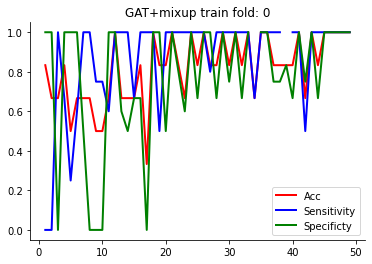

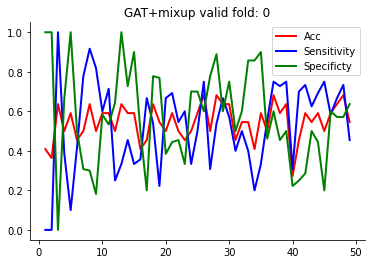

Fold: 0:  Test Acc: 0.5862, Test sensitivity:  0.5833, Test specificity:  0.5882
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 1: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 1: Epoch: 002, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 1: Epoch: 003, Train Acc: 0.6667, Train sensitivity:  0.3333, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.0909, Valid specificity:  0.8182
Fold: 1: Epoch: 004, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 1: Epoch: 005, Train Acc: 0.6667, Train sensitivity:  0.7500, Train specificity:  0.5000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.7692, Valid specificity:  0.1111
Fold: 1: Epoch: 006, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.5000 
					 Valid Acc: 0.4091,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 1: Epoch: 030, Train Acc: 0.8333, Train sensitivity:  nan, Train specificity:  0.8333 
					 Valid Acc: 0.5455, Valid sensitivity:  0.5385, Valid specificity:  0.5556
Fold: 1: Epoch: 031, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.7500, Valid specificity:  0.2000
Fold: 1: Epoch: 032, Train Acc: 0.8333, Train sensitivity:  0.7500, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.4167, Valid specificity:  0.6000
Fold: 1: Epoch: 033, Train Acc: 0.6667, Train sensitivity:  0.7500, Train specificity:  0.5000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.7778, Valid specificity:  0.2308
Fold: 1: Epoch: 034, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.5000, Valid specificity:  0.5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 1: Epoch: 035, Train Acc: 1.0000, Train sensitivity:  nan, Train specificity:  1.0000 
					 Valid Acc: 0.3636, Valid sensitivity:  0.5455, Valid specificity:  0.1818
Fold: 1: Epoch: 036, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.7273, Valid specificity:  0.4545
Fold: 1: Epoch: 037, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.7778, Valid specificity:  0.2308
Fold: 1: Epoch: 038, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.6923, Valid specificity:  0.4444
Fold: 1: Epoch: 039, Train Acc: 0.8333, Train sensitivity:  0.8000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.5000, Valid specificity:  0.4167
Fold: 1: Epoch: 040, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.5909, Va

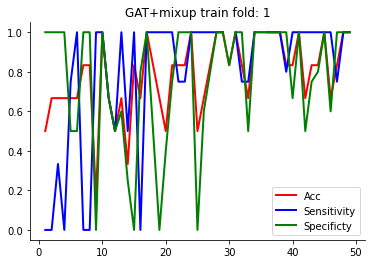

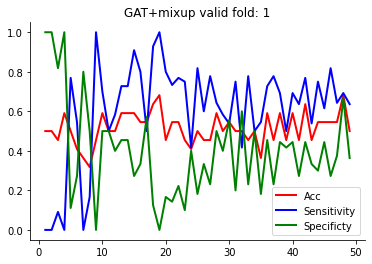

Fold: 1:  Test Acc: 0.6552, Test sensitivity:  0.7857, Test specificity:  0.5333
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 2: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 2: Epoch: 002, Train Acc: 0.1667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.7273, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 003, Train Acc: 0.6667, Train sensitivity:  0.6667, Train specificity:  0.6667 
					 Valid Acc: 0.6818, Valid sensitivity:  0.1250, Valid specificity:  1.0000
Fold: 2: Epoch: 004, Train Acc: 0.3333, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 005, Train Acc: 0.8333, Train sensitivity:  0.8000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.1818, Valid specificity:  0.9091
Fold: 2: Epoch: 006, Train Acc: 0.8333, Train sensitivity:  0.6667, Train specificity:  1.0000 
					 Valid Acc: 0.4545,

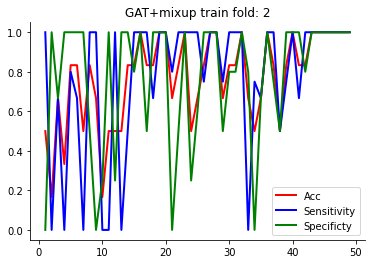

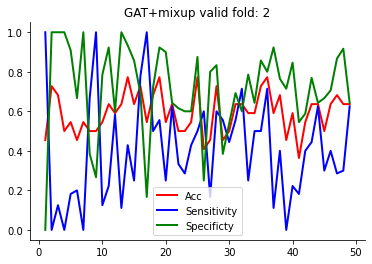

Fold: 2:  Test Acc: 0.3448, Test sensitivity:  0.5714, Test specificity:  0.2727
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 3: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 002, Train Acc: 0.5000, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 3: Epoch: 003, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.3182, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 3: Epoch: 004, Train Acc: 0.5000, Train sensitivity:  0.7500, Train specificity:  0.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.9000, Valid specificity:  0.0000
Fold: 3: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.3333, Train specificity:  0.6667 
					 Valid Acc: 0.5000, Valid sensitivity:  0.9000, Valid specificity:  0.1667
Fold: 3: Epoch: 006, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.8000 
					 Valid Acc: 0.5000,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 3: Epoch: 020, Train Acc: 0.8333, Train sensitivity:  nan, Train specificity:  0.8333 
					 Valid Acc: 0.3636, Valid sensitivity:  0.4167, Valid specificity:  0.3000
Fold: 3: Epoch: 021, Train Acc: 0.8333, Train sensitivity:  0.7500, Train specificity:  1.0000 
					 Valid Acc: 0.6364, Valid sensitivity:  0.6364, Valid specificity:  0.6364
Fold: 3: Epoch: 022, Train Acc: 0.8333, Train sensitivity:  0.7500, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.5000, Valid specificity:  0.6667
Fold: 3: Epoch: 023, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.6000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.9000, Valid specificity:  0.2500
Fold: 3: Epoch: 024, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.4545, Valid sensitivity:  0.7778, Valid specificity:  0.2308
Fold: 3: Epoch: 025, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.8000 
					 Valid Acc: 0.6364, Va

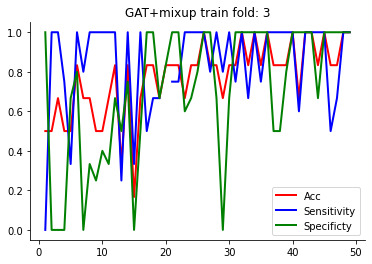

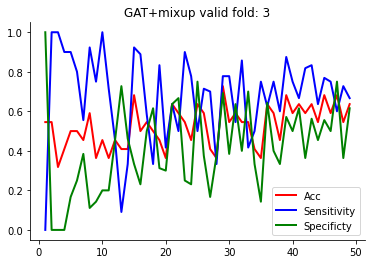

Fold: 3:  Test Acc: 0.7241, Test sensitivity:  0.5833, Test specificity:  0.8235
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 4: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 002, Train Acc: 0.3333, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 003, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 4: Epoch: 004, Train Acc: 0.6667, Train sensitivity:  0.7500, Train specificity:  0.5000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.2727, Valid specificity:  0.9091
Fold: 4: Epoch: 005, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.5556, Valid specificity:  0.5385
Fold: 4: Epoch: 006, Train Acc: 0.8333, Train sensitivity:  0.7500, Train specificity:  1.0000 
					 Valid Acc: 0.6364,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 4: Epoch: 042, Train Acc: 1.0000, Train sensitivity:  nan, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.5000, Valid specificity:  0.7000
Fold: 4: Epoch: 043, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.4545, Valid specificity:  0.4545
Fold: 4: Epoch: 044, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.4000, Valid specificity:  0.4167
Fold: 4: Epoch: 045, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.3636, Valid specificity:  0.5455
Fold: 4: Epoch: 046, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.5385, Valid specificity:  0.5556
Fold: 4: Epoch: 047, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.5455, Va

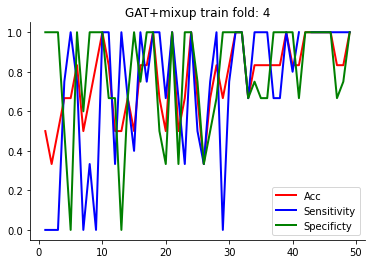

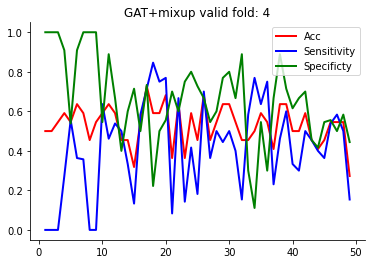

Fold: 4:  Test Acc: 0.6207, Test sensitivity:  0.5882, Test specificity:  0.6667
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 5: Epoch: 001, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.3182, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 002, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.4091, Valid sensitivity:  0.4167, Valid specificity:  0.4000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 5: Epoch: 003, Train Acc: 1.0000, Train sensitivity:  nan, Train specificity:  1.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 004, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.8000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.3636, Valid specificity:  0.5455
Fold: 5: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.2308, Valid specificity:  0.6667
Fold: 5: Epoch: 006, Train Acc: 0.1667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  0.1667, Valid specificity:  0.7000
Fold: 5: Epoch: 007, Train Acc: 0.6667, Train sensitivity:  0.6000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.2727, Valid specificity:  0.7273
Fold: 5: Epoch: 008, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  0.7500 
					 Valid Acc: 0.5455, Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 5: Epoch: 015, Train Acc: 0.8333, Train sensitivity:  nan, Train specificity:  0.8333 
					 Valid Acc: 0.5000, Valid sensitivity:  0.4615, Valid specificity:  0.5556
Fold: 5: Epoch: 016, Train Acc: 0.8333, Train sensitivity:  0.5000, Train specificity:  1.0000 
					 Valid Acc: 0.7273, Valid sensitivity:  0.4545, Valid specificity:  1.0000
Fold: 5: Epoch: 017, Train Acc: 0.6667, Train sensitivity:  0.5000, Train specificity:  1.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.3636, Valid specificity:  0.6364
Fold: 5: Epoch: 018, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.3333 
					 Valid Acc: 0.7727, Valid sensitivity:  0.9286, Valid specificity:  0.5000
Fold: 5: Epoch: 019, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.3571, Valid specificity:  1.0000
Fold: 5: Epoch: 020, Train Acc: 0.6667, Train sensitivity:  0.7500, Train specificity:  0.5000 
					 Valid Acc: 0.6818, Va

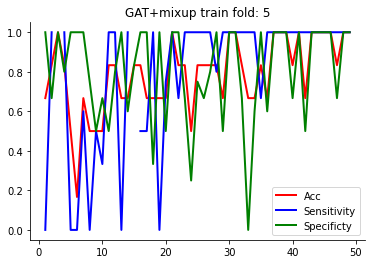

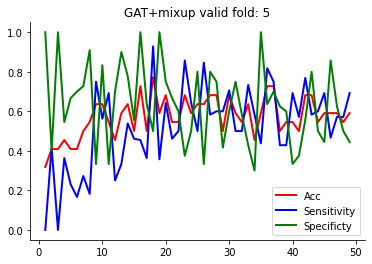

Fold: 5:  Test Acc: 0.5517, Test sensitivity:  0.6429, Test specificity:  0.4667
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 6: Epoch: 001, Train Acc: 0.8333, Train sensitivity:  nan, Train specificity:  0.8333 
					 Valid Acc: 0.6818, Valid sensitivity:  0.4545, Valid specificity:  0.9091
Fold: 6: Epoch: 002, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.6364, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 6: Epoch: 003, Train Acc: 0.5000, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 6: Epoch: 004, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  0.7500 
					 Valid Acc: 0.6364, Valid sensitivity:  0.1111, Valid specificity:  1.0000
Fold: 6: Epoch: 005, Train Acc: 0.1667, Train sensitivity:  0.5000, Train specificity:  0.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.7000, Valid specificity:  0.3333
Fold: 6: Epoch: 006, Train Acc: 0.8333, Train sensitivity:  0.5000, Train specificity:  1.0000 
					 Valid Acc: 0.7727, Va

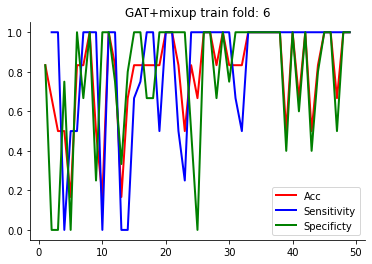

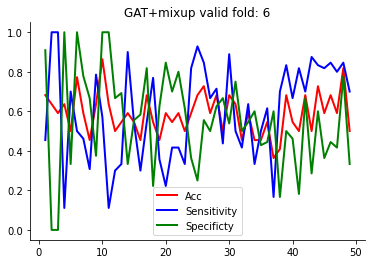

Fold: 6:  Test Acc: 0.4828, Test sensitivity:  0.6250, Test specificity:  0.3077
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 7: Epoch: 001, Train Acc: 0.3333, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.4091, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 7: Epoch: 002, Train Acc: 0.3333, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6364, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 003, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.7273, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 004, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.5000, Train specificity:  0.5000 
					 Valid Acc: 0.6364, Valid sensitivity:  0.6250, Valid specificity:  0.6429
Fold: 7: Epoch: 006, Train Acc: 0.5000, Train sensitivity:  0.2500, Train specificity:  1.0000 
					 Valid Acc: 0.5909,

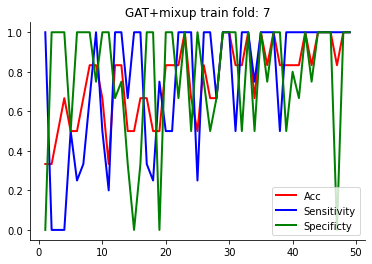

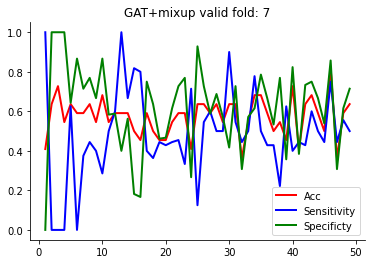

Fold: 7:  Test Acc: 0.6207, Test sensitivity:  0.7000, Test specificity:  0.5789
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 8: Epoch: 001, Train Acc: 0.6667, Train sensitivity:  0.3333, Train specificity:  1.0000 
					 Valid Acc: 0.6818, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 002, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6818, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 8: Epoch: 003, Train Acc: 0.3333, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 8: Epoch: 004, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.1000, Valid specificity:  1.0000
Fold: 8: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.4000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.5000, Valid specificity:  0.7000
Fold: 8: Epoch: 006, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4091,

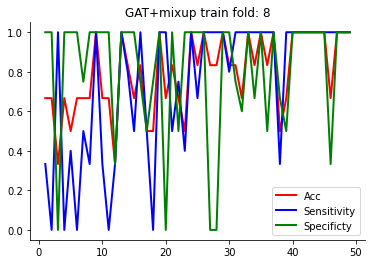

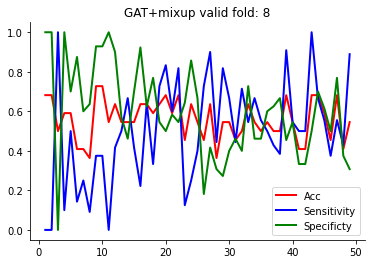

Fold: 8:  Test Acc: 0.4828, Test sensitivity:  0.7692, Test specificity:  0.2500
GNN(
  (conv1): GATConv(266, 32, heads=32)
  (conv3): GATConv(1024, 16, heads=16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 9: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  0.6000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.3636, Valid specificity:  0.7273
Fold: 9: Epoch: 002, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 9: Epoch: 003, Train Acc: 0.6667, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 9: Epoch: 004, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 9: Epoch: 005, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  0.7500 
					 Valid Acc: 0.5455, Valid sensitivity:  0.1250, Valid specificity:  0.7857
Fold: 9: Epoch: 006, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.5000 
					 Valid Acc: 0.6818,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Fold: 9: Epoch: 026, Train Acc: 0.8333, Train sensitivity:  0.8333, Train specificity:  nan 
					 Valid Acc: 0.6818, Valid sensitivity:  0.7692, Valid specificity:  0.5556
Fold: 9: Epoch: 027, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.3333 
					 Valid Acc: 0.8182, Valid sensitivity:  0.8750, Valid specificity:  0.7857
Fold: 9: Epoch: 028, Train Acc: 0.3333, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.7727, Valid sensitivity:  0.6364, Valid specificity:  0.9091
Fold: 9: Epoch: 029, Train Acc: 0.6667, Train sensitivity:  0.7500, Train specificity:  0.5000 
					 Valid Acc: 0.5455, Valid sensitivity:  0.4286, Valid specificity:  0.6000
Fold: 9: Epoch: 030, Train Acc: 0.5000, Train sensitivity:  1.0000, Train specificity:  0.4000 
					 Valid Acc: 0.6364, Valid sensitivity:  0.9000, Valid specificity:  0.4167
Fold: 9: Epoch: 031, Train Acc: 0.8333, Train sensitivity:  1.0000, Train specificity:  0.6667 
					 Valid Acc: 0.5455, Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Fold: 9: Epoch: 036, Train Acc: 1.0000, Train sensitivity:  nan, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.5000, Valid specificity:  0.6667
Fold: 9: Epoch: 037, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4545, Valid sensitivity:  0.5000, Valid specificity:  0.4375
Fold: 9: Epoch: 038, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.7000, Valid specificity:  0.5000
Fold: 9: Epoch: 039, Train Acc: 0.6667, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5909, Valid sensitivity:  0.8333, Valid specificity:  0.3000
Fold: 9: Epoch: 040, Train Acc: 1.0000, Train sensitivity:  1.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6818, Valid sensitivity:  0.7273, Valid specificity:  0.6364
Fold: 9: Epoch: 041, Train Acc: 0.8333, Train sensitivity:  0.5000, Train specificity:  1.0000 
					 Valid Acc: 0.5455, Va

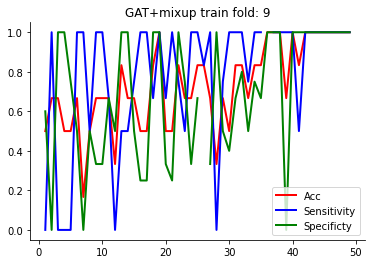

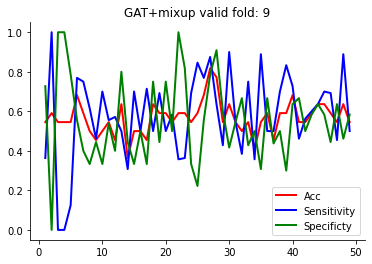

Fold: 9:  Test Acc: 0.5172, Test sensitivity:  0.4167, Test specificity:  0.5882


In [40]:
k_fold(10, dataset=data_processed, num_epochs=50)